# New South Wales Department of Education (NSW DOE) - Data Case Study 
## Data Analysis

In [3]:
# import necessary libraries
import pandas as pd
import duckdb
from ydata_profiling import ProfileReport
from scipy.stats import ttest_ind
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

### Connect to the database

In [4]:
# connect to db
con = duckdb.connect('../../database/nsw_doe_data_case_study.duckdb',read_only=False)

## Exploratory Data Analysis:

#### Data profile check

In [ ]:
# Data profile check of public_school_nsw_master_dataset
df = con.sql('select * from public_school_nsw_master_dataset').df()
profile_public_school_nsw_master_dataset = ProfileReport(df, title="Public School NSW Data Profiling Report")
profile_public_school_nsw_master_dataset.to_file("profile_public_school_nsw_master_dataset.html")
profile_public_school_nsw_master_dataset

In [ ]:
# Data profile check of multi_age_composite_unpivoted
df = con.sql('select * from multi_age_composite_unpivoted').df()
profile_multi_age_composite_unpivoted = ProfileReport(df, title="Multi Age Composite Profiling Report")
profile_multi_age_composite_unpivoted.to_file("profile_multi_age_composite_unpivoted.html")
profile_multi_age_composite_unpivoted

In [ ]:
# Data profile check of student_attendance_unpivoted
df = con.sql('select * from student_attendance_unpivoted').df()
profile_student_attendance_dataset = ProfileReport(df, title="Student Attendance Profiling Report")
profile_student_attendance_dataset.to_file("student_attendance_unpivoted.html")
profile_student_attendance_dataset

In [ ]:
# Data profile check of model data - nsw_composite_school_attendance_data
df = con.sql('select * from nsw_composite_school_attendance_data').df()
profile_student_attendance_dataset = ProfileReport(df, title="nsw_composite_school_attendance_data Profiling Report")
profile_student_attendance_dataset.to_file("nsw_composite_school_attendance_data.html")
profile_student_attendance_dataset

### Average Trends Over Years of Attendence and composite classes

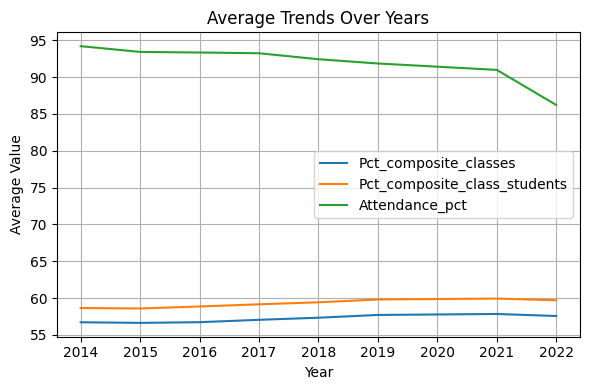

In [5]:
query = """
SELECT
    Year,
    AVG(Pct_composite_classes) AS Avg_Pct_composite_classes,
    AVG(Pct_composite_class_students) AS Avg_Pct_composite_class_students,
    AVG(Attendance_pct) AS Avg_Attendance_pct
FROM nsw_composite_school_attendance_data
GROUP BY Year
"""
results = con.execute(query).fetchall()

df = pd.DataFrame(results, columns=["Year", "Avg_Pct_composite_classes", "Avg_Pct_composite_class_students", "Avg_Attendance_pct"])

# Create a line chart
plt.figure(figsize=(6, 4))

columns_to_plot = ["Avg_Pct_composite_classes", "Avg_Pct_composite_class_students", "Avg_Attendance_pct"]

for column in columns_to_plot:
    plt.plot(df["Year"], df[column], label=column.replace("Avg_", ""))

plt.title("Average Trends Over Years")
plt.xlabel("Year")
plt.ylabel("Average Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


#### Correlation Matrix of the Data Model

                               School_code          Year  \
School_code                   1.000000e+00  1.035085e-14   
Year                          1.035085e-14  1.000000e+00   
Composite_class_count         1.008315e-01  4.502593e-02   
Composite_class_students      1.321840e-01  2.671974e-02   
Pct_composite_classes        -2.920105e-01  1.155339e-02   
Pct_composite_class_students -2.875473e-01  1.294387e-02   
Attendance_pct                6.139386e-02 -5.386230e-01   
ICSEA_value                   1.410737e-01  2.460875e-15   
latest_year_enrolment_FTE     3.194721e-01 -5.380596e-16   
Latitude                     -1.461989e-01  3.155740e-15   
Longitude                     8.449003e-02 -1.046173e-13   

                              Composite_class_count  Composite_class_students  \
School_code                                0.100832                  0.132184   
Year                                       0.045026                  0.026720   
Composite_class_count               

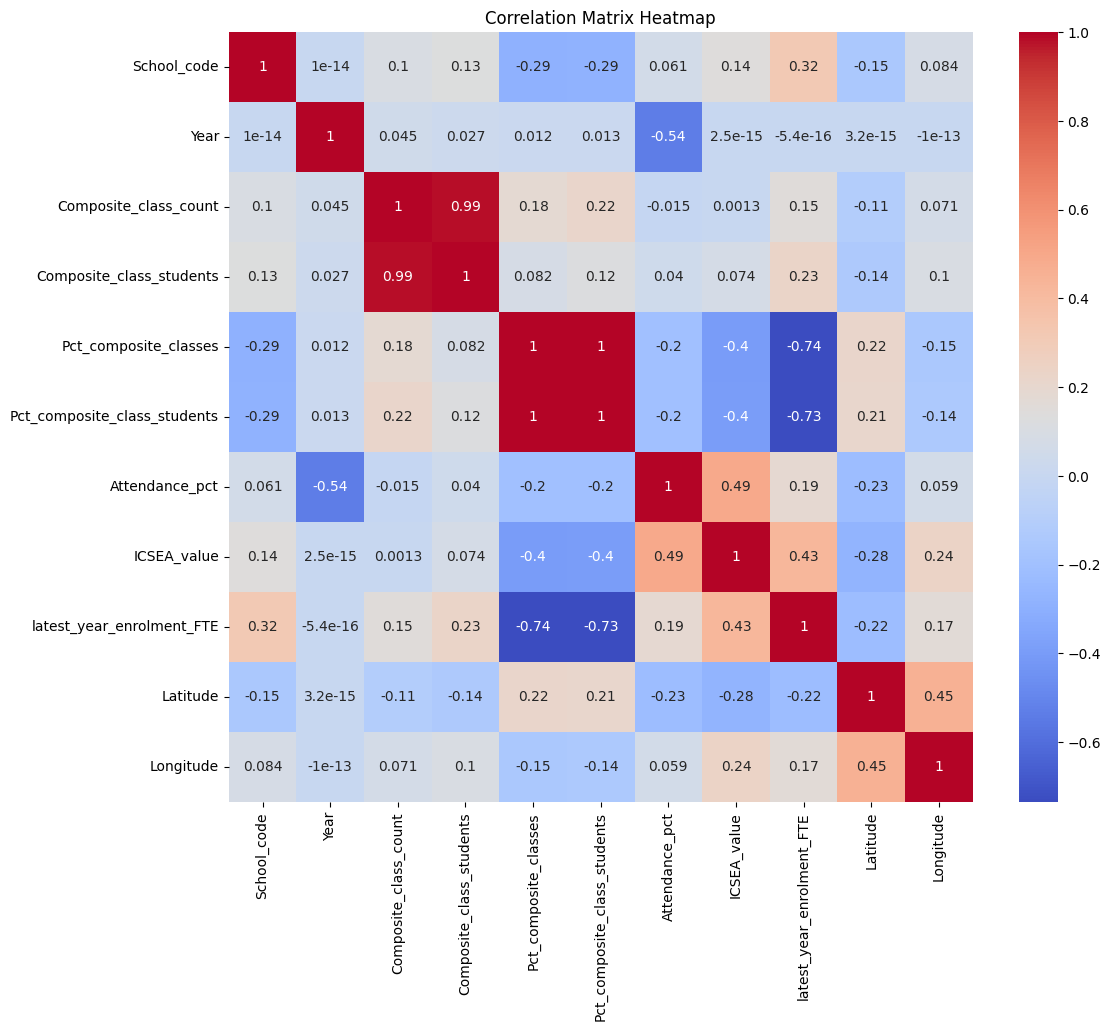

In [6]:
# Execute the SELECT statement
query = "SELECT * FROM nsw_composite_school_attendance_data;"
df = con.execute(query).fetchdf()
# Select only numeric columns
numeric_cols = df.select_dtypes(include=['float64', 'int64', 'float32', 'int32']).columns
numeric_df = df[numeric_cols]
# Compute the correlation matrix for numeric columns only
correlation_matrix = numeric_df.corr()
# Display the correlation matrix
print(correlation_matrix)
# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=True)
plt.title("Correlation Matrix Heatmap")
plt.show()

#### Q-Q plot (Quantile-Quantile plot): compare two probability distributions

In [ ]:
query = "SELECT * FROM nsw_composite_school_attendance_data;"
df = con.execute(query).fetchdf()

# Select only numeric columns
numeric_cols = df.select_dtypes(include=['float64', 'int64', 'float32', 'int32']).columns

# Plot Q-Q plots for each numeric column
for col in numeric_cols:
    plt.figure(figsize=(8, 6))
    stats.probplot(df[col], plot=plt)
    plt.title(f'Q-Q Plot for {col}')
    plt.show()


#### Distribution Plots:

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
query = "SELECT * FROM nsw_composite_school_attendance_data;"
df = con.execute(query).fetchdf()
numeric_cols = df.select_dtypes(include=['float64', 'int64', 'float32', 'int32']).columns
# Exclude 'School_code' and 'Year'
numeric_cols = numeric_cols.drop(['School_code', 'Year'])
n_cols = 3  
n_rows = -(-len(numeric_cols) // n_cols)  
# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, n_rows*3))
if n_rows == 1:
    axes = axes.reshape(1, -1)
for i, col in enumerate(numeric_cols):
    sns.histplot(df[col], bins=30, kde=True, ax=axes[i//n_cols, i%n_cols])
    axes[i//n_cols, i%n_cols].set_title(f'Distribution for {col}')
    axes[i//n_cols, i%n_cols].grid(True)
# Remove any unused subplots
for j in range(i+1, n_rows*n_cols):
    fig.delaxes(axes.flatten()[j])
plt.tight_layout()
plt.suptitle('Distribution Plots for Numeric Columns', y=1.05)
plt.show()

#### Pairwise relationships and distributions for numeric columns:

In [ ]:
# Execute the SELECT statement
query = "SELECT * FROM nsw_composite_school_attendance_data;"
df = con.execute(query).fetchdf()
# Select only numeric columns
numeric_cols = df.select_dtypes(include=['float64', 'int64', 'float32', 'int32']).columns
# Exclude 'School_code' and 'Year'
numeric_cols = numeric_cols.drop(['School_code', 'Year'])
# Pair Plots for numeric columns
sns.pairplot(df[numeric_cols])
plt.suptitle('Pair Plots for Numeric Columns', y=1.02)
plt.show()


## Action: Data analysis:

<span style="color:yellow; font-size:30px;">Hypothesis Formulation:</span>

| Title                   | Description                                                          |
|-------------------------|----------------------------------------------------------------------|
| **Objective**           | Determine if multi-age composite classes have an impact on attendance rates. |
| **Null Hypothesis (H₀)** | Multi-age composite classes have no impact on attendance rates.      |
| **Alternative Hypothesis (H₁)** | Multi-age composite classes have a significant impact on attendance rates. |


<span style="color:yellow; font-size:30px;">Statistical Test:</span>

In [7]:
# Query data from the database
columns = [
    "Composite_class_count", "Composite_class_students", "Pct_composite_classes", 
    "Pct_composite_class_students", "Attendance_pct", "ICSEA_value", 
    "latest_year_enrolment_FTE", "Indigenous_pct", "LBOTE_pct"
]
query = f"SELECT {','.join(columns)} FROM nsw_composite_school_attendance_data"
df = con.execute(query).fetch_df()

# Drop rows with 'np' and blank values in the specified columns
df = df[~df['Indigenous_pct'].isin(['np', ''])]
df = df[~df['LBOTE_pct'].isin(['np', ''])]
df = df[~df['ICSEA_value'].isin([''])]

# Convert the columns to numeric
for col in columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Descriptive statistics
desc_stats = df.describe()
print(desc_stats)

# Correlation matrix
correlations = df.corr()
print(correlations)

# Separate schools based on ICSEA_value
mean_icsea = df['ICSEA_value'].mean()
high_icsea = df[df['ICSEA_value'] > mean_icsea]
low_icsea = df[df['ICSEA_value'] <= mean_icsea]

# T-tests
significant_cols = []

for col in columns:
    t_stat, p_val = ttest_ind(high_icsea[col], low_icsea[col], nan_policy='omit')  # omitting NaN values
    
    # Apply Bonferroni correction for multiple testing
    adjusted_alpha = 0.05 / len(columns)
    
    if p_val < adjusted_alpha:
        significant_cols.append(col)

print("\nColumns with significant differences between high and low ICSEA schools:")
print(significant_cols)

       Composite_class_count  Composite_class_students  Pct_composite_classes  \
count            8560.000000               8560.000000            8488.000000   
mean                4.894860                123.079089              49.459126   
std                 3.421125                 90.654820              32.548519   
min                 0.000000                  0.000000               0.000000   
25%                 2.000000                 54.000000              17.600000   
50%                 4.000000                106.000000              50.000000   
75%                 7.000000                176.000000              80.000000   
max                29.000000                779.000000             100.000000   

       Pct_composite_class_students  Attendance_pct  ICSEA_value  \
count                   8488.000000     8444.000000  8528.000000   
mean                      51.893829       91.847221   980.780488   
std                       33.099361        3.764522    94.727081  

<span style="color:yellow; font-size:30px;">Descriptive Statistics:</span>

| Feature                                           | Correlation Value | Summary                                       |
|---------------------------------------------------|-------------------|-----------------------------------------------|
| `Composite_class_count vs. Attendance_pct`        | -0.013698         | Very weak negative relation.                  |
| `Composite_class_students vs. Attendance_pct`     | 0.040343          | Slight increase with more students in composite classes. |
| `Pct_composite_classes vs. Attendance_pct`        | -0.208262         | Schools with more composite classes might see a bit less attendance. |
| `Pct_composite_class_students vs. Attendance_pct`| -0.205552         | More students in composite classes could lead to a slight drop in attendance. |

**Overall Summary**: 

The more composite classes or students there are, there might be a slight drop in attendance. However, the relationship is generally weak, indicating other factors could play a significant role in attendance rates.


<span style="color:yellow; font-size:30px;">T-tests: Statistical Significance:</span>

In [ ]:
# Split the dataframe based on ICSEA_value median
median_icsea = df['ICSEA_value'].median()
high_icsea_df = df[df['ICSEA_value'] > median_icsea]
low_icsea_df = df[df['ICSEA_value'] <= median_icsea]

# Columns to run t-tests on
columns = [
    "Composite_class_count", "Composite_class_students", "Pct_composite_classes",
    "Pct_composite_class_students", "Attendance_pct", "latest_year_enrolment_FTE",
    "Indigenous_pct", "LBOTE_pct"
]

# Running t-tests
results = {}
for col in columns:
    t_stat, p_value = stats.ttest_ind(high_icsea_df[col], low_icsea_df[col], nan_policy='omit')
    results[col] = {"t-statistic": t_stat, "p-value": p_value}

results_df = pd.DataFrame(results).T
print(results_df)

<span style="color:yellow; font-size:25px;">Outcome of T-test:</span>

| Metric                          | t-statistic | p-value        | Interpretation                                                                       |
|---------------------------------|-------------|----------------|--------------------------------------------------------------------------------------|
| `Pct_composite_classes`         | -23.572692  | Close to 0     | Highly significant difference between high and low ICSEA schools.                     |
| `Pct_composite_class_students`  | -23.001235  | Close to 0     | Significant difference in student percentages in composite classes by ICSEA.          |
| `Attendance_pct`                | 35.825538   | Close to 0     | Significant attendance difference between high and low ICSEA schools.                 |

**Correlation Analysis**:
- `Pct_composite_classes vs. Attendance_pct`: Correlation = -0.208262 (weak negative)
- `Pct_composite_class_students vs. Attendance_pct`: Correlation = -0.205552 (weak negative)

**Conclusions**: 
- Both composite class metrics show a significant difference between high and low ICSEA schools.
- There's a weak negative correlation between composite classes/students and attendance.
- However, correlation doesn't imply causation. Other factors could influence both the use of composite classes and attendance rates.


<span style="color:yellow; font-size:30px;">Hypothesis Outcome:</span>

<span style="color:green; font-size:15px;">(If the t-test p-value is below a certain significance level (usually 0.05), we reject the null hypothesis, indicating that there's a significant difference in attendance rates.)</span>

## Analysis Results

| Metric                         | p-value                     | Interpretation                                                                                                    |
|--------------------------------|-----------------------------|-------------------------------------------------------------------------------------------------------------------|
| `Composite_class_count`        | 0.1996                      | No significant difference in count of composite classes between high & low ICSEA schools.                          |
| `Composite_class_students`     | 0.0004807                   | Significant difference.                                                                                           |
| `Pct_composite_classes`        | Virtually 0                 | Significant difference.                                                                                           |
| `Pct_composite_class_students` | Virtually 0                 | Significant difference.                                                                                           |
| `Attendance_pct`               | Virtually 0                 | Significant attendance difference.                                                                               |
| `latest_year_enrolment_FTE`    | Virtually 0                 | Significant difference.                                                                                           |
| `Indigenous_pct`               | 0                           | Significant difference.                                                                                           |
| `LBOTE_pct`                    | Virtually 0                 | Significant difference.                                                                                           |

## Conclusions
- Only `Composite_class_count` doesn't show a significant difference between high and low ICSEA schools.
- Metrics related to composite classes (`Pct_composite_classes` and `Pct_composite_class_students`) and attendance (`Attendance_pct`) differ significantly between the two school types.
- This indicates a relationship between multi-age composite classes and attendance across ICSEA levels. Further detailed analyses are needed to determine causation.


<span style="color:yellow; font-size:30px;">Multiple Linear Regression Analysis:</span>

In [14]:
# Drop rows with 'np' and blank values in the specified columns
df = df.dropna()  # Drop rows with NaN values
df = df[~np.isinf(df).any(axis=1)]  # Drop rows with Inf values
df = df[~df['Indigenous_pct'].isin(['np', ''])]
df = df[~df['LBOTE_pct'].isin(['np', ''])]
df = df[~df['ICSEA_value'].isin([''])]

# Define the predictor variables (features)
X = df[['Composite_class_students', 'Composite_class_count','Pct_composite_classes', 'Pct_composite_class_students', 'ICSEA_value', 'latest_year_enrolment_FTE', 'Indigenous_pct', 'LBOTE_pct']]

# Add a constant term to the predictor variables
X = sm.add_constant(X)

# Define the target variable
y = df['Attendance_pct']

# Fit the regression model
model = sm.OLS(y, X).fit()

# Get the summary of the regression analysis
summary = model.summary()
print(summary)

                            OLS Regression Results                            
Dep. Variable:         Attendance_pct   R-squared:                       0.319
Model:                            OLS   Adj. R-squared:                  0.319
Method:                 Least Squares   F-statistic:                     493.5
Date:                Sun, 20 Aug 2023   Prob (F-statistic):               0.00
Time:                        01:49:18   Log-Likelihood:                -21522.
No. Observations:                8431   AIC:                         4.306e+04
Df Residuals:                    8422   BIC:                         4.312e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

## Updated Multiple Linear Regression Analysis

### General Statistics:
- **R-squared:** 0.319 (31.9% of variance in `Attendance_pct` is explained by the model.)
- **Adjusted R-squared:** 0.319 (Model is a good fit for explaining variation in `Attendance_pct`.)

### Impact of Independent Variables on `Attendance_pct`:

| Independent Variable          | Coefficient (coef) | Interpretation                                                               |
|-------------------------------|--------------------|------------------------------------------------------------------------------|
| `Composite_class_students`    | 0.0507             | A unit increase leads to a 0.0507 increase in Attendance_pct.                |
| `Composite_class_count`       | -1.3036            | A unit increase leads to a -1.3036 decrease in Attendance_pct.               |
| `Pct_composite_classes`       | 0.1512             | A unit increase leads to a 0.1512 increase in Attendance_pct.                |
| `Pct_composite_class_students`| -0.1501            | A unit increase leads to a -0.1501 decrease in Attendance_pct.               |
| `ICSEA_value`                 | 0.0117             | A unit increase leads to a 0.0117 increase in Attendance_pct.                |
| `latest_year_enrolment_FTE`   | -0.0011            | A unit increase leads to a -0.0011 decrease in Attendance_pct.               |
| `Indigenous_pct`              | -0.0548            | A unit increase leads to a -0.0548 decrease in Attendance_pct.               |
| `LBOTE_pct`                   | -0.0074            | A unit increase leads to a -0.0074 decrease in Attendance_pct.               |

### P-values:
All p-values are close to zero, indicating the significance of each variable in the model.

### Conclusion:
Variables like `Composite_class_students`, `Composite_class_count`, and others significantly impact attendance rates. Notably, more composite classes are linked to reduced attendance. This offers a deeper understanding of factors affecting attendance in multi-age composite class schools.


<span style="color:yellow; font-size:30px;">Machine Learning - Random Forest:</span>

In [15]:
# Select predictor variables
predictors = ['Composite_class_students', 'Composite_class_count','Pct_composite_classes', 'Pct_composite_class_students', 'ICSEA_value', 'latest_year_enrolment_FTE', 'Indigenous_pct', 'LBOTE_pct']

# Define predictor matrix X and target variable y
X = df[predictors]
y = df['Attendance_pct']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Get feature importances
feature_importances = rf_model.feature_importances_

# Print feature importances
for feature, importance in zip(predictors, feature_importances):
    print(f"{feature}: {importance}")

# Predict attendance rates on the test set
y_pred = rf_model.predict(X_test)

# Calculate Mean Squared Error
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

Composite_class_students: 0.18011545927871678
Composite_class_count: 0.037108093319189114
Pct_composite_classes: 0.06428291964147513
Pct_composite_class_students: 0.10028358064861378
ICSEA_value: 0.34153035720571395
latest_year_enrolment_FTE: 0.10854447606088662
Indigenous_pct: 0.11252638227631924
LBOTE_pct: 0.05560873156908551
Mean Squared Error: 9.060393155587107


#### <span style="color:green; font-size:20px;">Outcome of Machine Learning - Random Forest: </span>

## Insights from Random Forest Model:

| Feature                        | Importance | Interpretation                                               |
|--------------------------------|------------|--------------------------------------------------------------|
| **ICSEA_value**                | Highest    | Major predictor of attendance rates.                         |
| **Composite_class_students**   | High       | Significant contributor to predicting attendance rates.      |
| **Indigenous_pct**             | High       | Significant contributor to predicting attendance rates.      |
| **latest_year_enrolment_FTE**  | High       | Significant contributor to predicting attendance rates.      |
| **Pct_composite_class_students** | Moderate  |                                                              |
| **Pct_composite_classes**      | Moderate   |                                                              |
| **Composite_class_count**      | Low        |                                                              |
| **LBOTE_pct**                  | Low        |                                                              |

### Model Performance:

- **Mean Squared Error (MSE)**: Approximately 9.06.
   - Interpretation: Improved prediction of attendance rates compared to previous analyses.

### Conclusion:
The model indicates that socio-educational advantage, class size, student demographics, etc., play a role in attendance rates.


In [16]:
con.close()